In [19]:
import numpy as np
import matplotlib.pyplot as plt
import opt_einsum as oe
import sys
sys.path.append('/home/fioren_a/useful_repos/hydro_glasses')
from time import time
from ase.io import read,write
from ase import units
from hydro_glasses import lanczos,test_lanczos,hydrodynamic
from hydro_glasses import amorphous_tools as at
import os
import logging
from scipy import sparse
#multiprocessing
from multiprocessing import Pool
from scipy.optimize import curve_fit


In [20]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'

In [29]:
def lorentzian(w, w0, tau, norm):
    return norm*(tau/(tau**2 + (w-w0)**2))
def DHO(w, w0, tau, norm):
    return norm*(w*2*tau/((w*tau)**2 + (w**2-w0**2)**2))
def lor_2(w,gamma,norm, w0,eta):
    w0_complex=w0+1j*np.abs(gamma)
    y=w0_complex*eta/( (  w**2- w0_complex**2  )**2+(eta**2)* (w0_complex**2) )   

    return norm*np.imag(1j*y)

def DHO_2(w,gamma,norm, w0,eta):
    gamma=np.abs(gamma)
    num=norm*(2*gamma+eta)*w0
    den=( ( w**2-w0**2-0.5*(gamma+eta)**2)**2+ w**2*(2*gamma+eta)**2  )
    return num/den
def crossover(w,a,wc,delta):
    return a*w**2*  ( 1+(wc/w)**(2*delta) )**(-1/delta) 
def quartic(x,a):
    return a*x**4
def compute_FWHM(x,y):
    ymax=np.max(y)
    imax=np.argmax(y)
    iminus=np.argmin(np.abs(y[x<x[imax]]-ymax/2))
    iplus=np.argmin(np.abs(y[x>x[imax]]-ymax/2))
    return x[imax],x[iplus+imax]-x[iminus]

# Load spectrum

The spectrum object contains, for each wave vector, the VDSF computed with $k$ lanczos steps and smearing $\eta$ on an angular frequency range $\omega$. It also contains the $\alpha,\beta$ coefficients of the continuous fraction expansion. Using them the spectrum can inexpensively computed for different frequencies and smearings. 

In [30]:

root='N1728/'
atoms = read(root+'replicated_atoms.xyz')
N=atoms.get_global_number_of_atoms()
n_modes=3
eta=1
k=200 #length chain
ortho=False

if not ortho:
    spectrum=np.load(root+'spectrum_k{}_eta{}.npy'.format(k,eta),allow_pickle=True).item()
else:
    spectrum=np.load(root+'spectrum_ortho_k{}_eta{}.npy'.format(k,eta),allow_pickle=True).item()


q=spectrum['Q']
spectrum
q=np.linalg.norm(q,axis=1)
w=spectrum['omega']
S_qw=np.zeros((n_modes,len(q),len(w)))
for ib,b in enumerate(['L','T']):
    for iq in range(len(q)):
        S_qw[ib,iq,:]=spectrum[iq][b]['S']

Text(0.5, 0.98, '$S(q,\\nu)$')

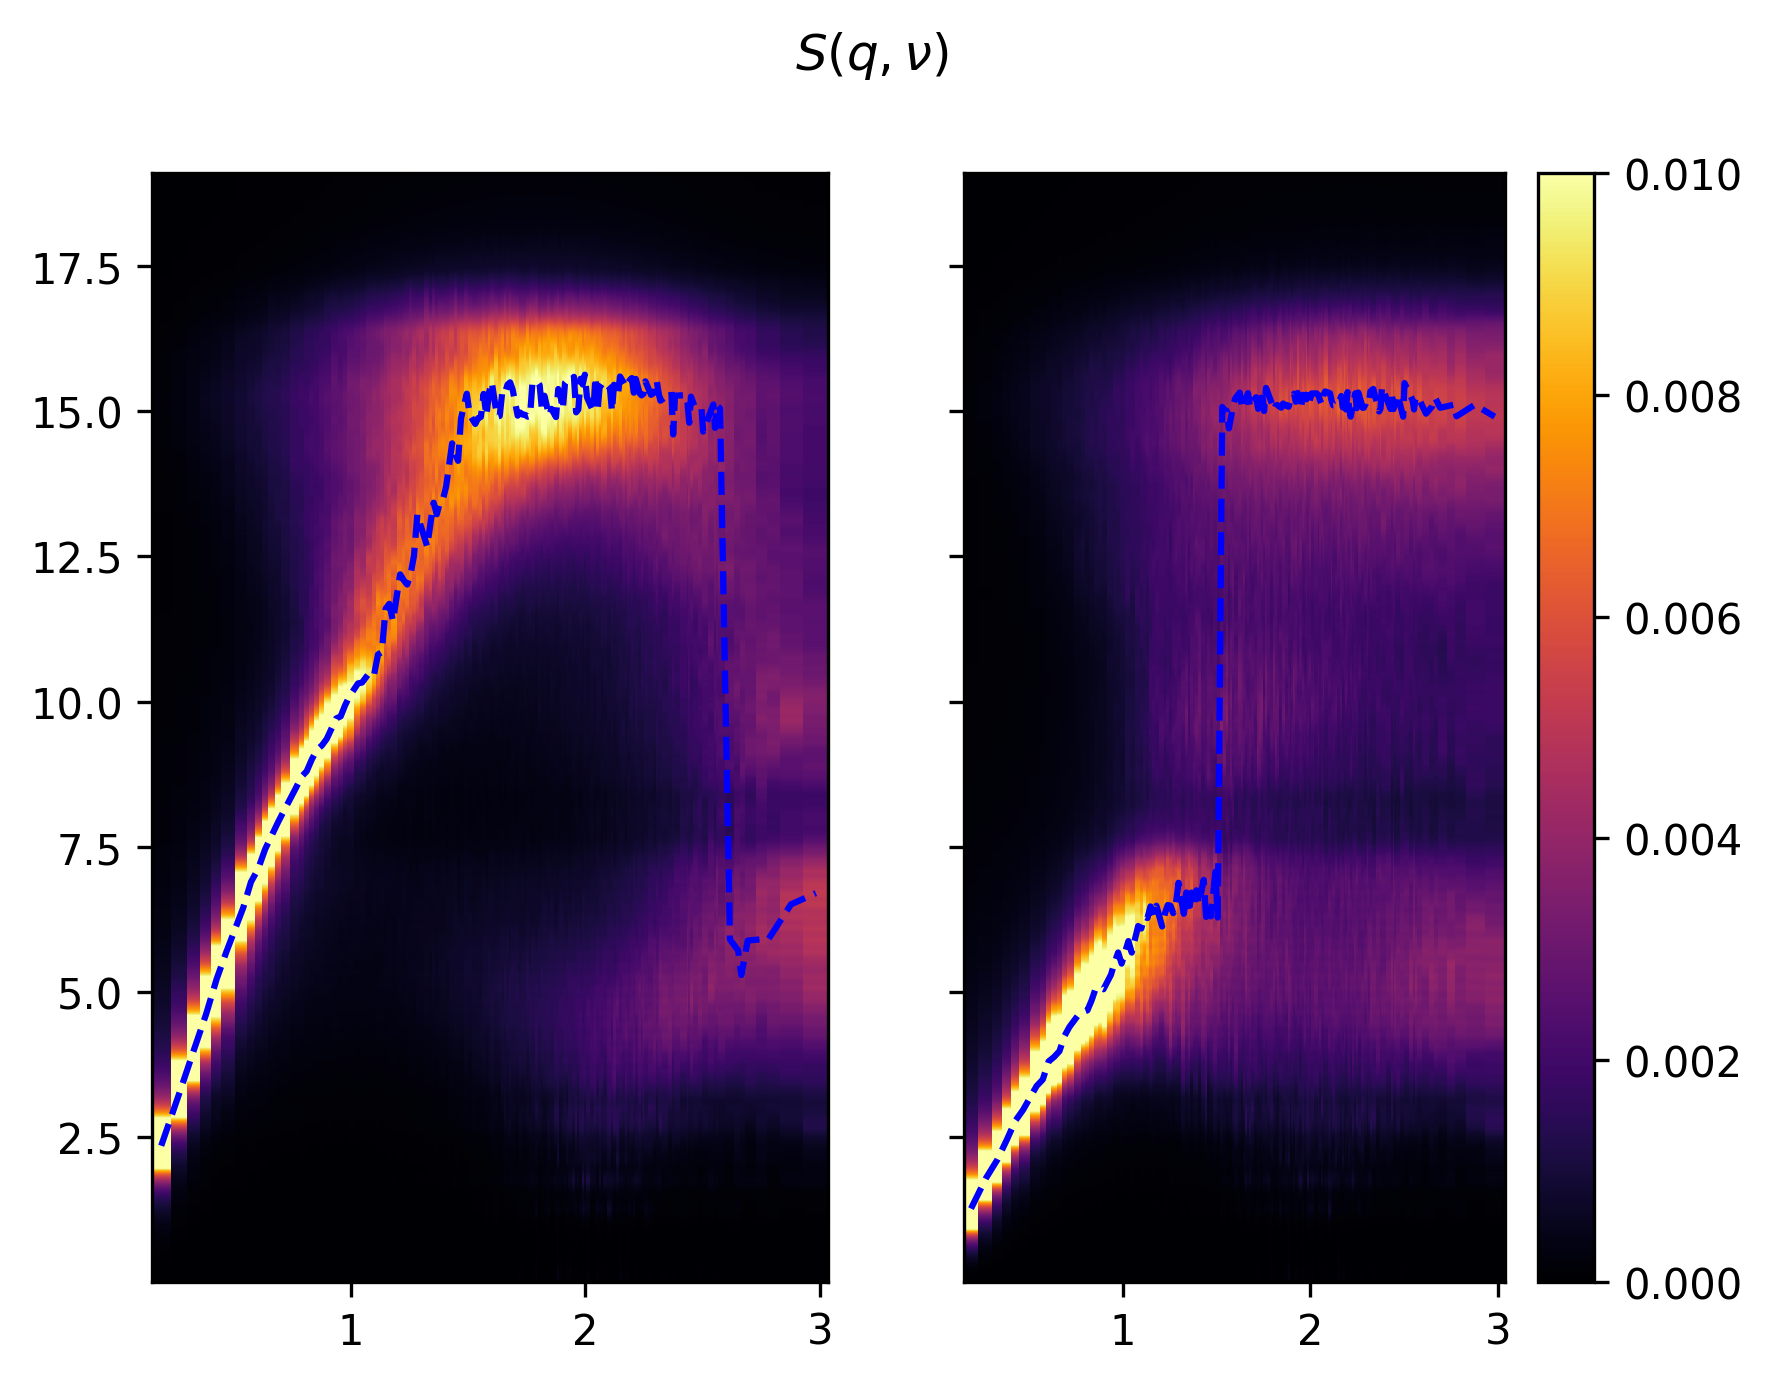

In [57]:
fig,axes=plt.subplots(ncols=2,sharey=True)
vmax=1e-2
for imode in range(2):
    ax=axes[imode]
    p=ax.pcolormesh(q,w/2/np.pi,w[:,np.newaxis]/2/np.pi*S_qw[imode,:,:].T,
                          shading = 'nearest',
                          vmin = 0,
                          vmax = vmax,
                          cmap = 'inferno'
                 )
    dispersion=w[np.argmax(w[np.newaxis,:]*S_qw[imode,:,:],axis=1)] ### it should give the acoustic dispersion in the lower frequency part
    # print(T_dispersion.shape)
    ax.plot(q,dispersion/2/np.pi,'--',color='b')
    if imode==1:
        fig.colorbar(p, ax=ax)
fig.suptitle('$S(q,\\nu)$')


# Todo: test convergence lanczos steps

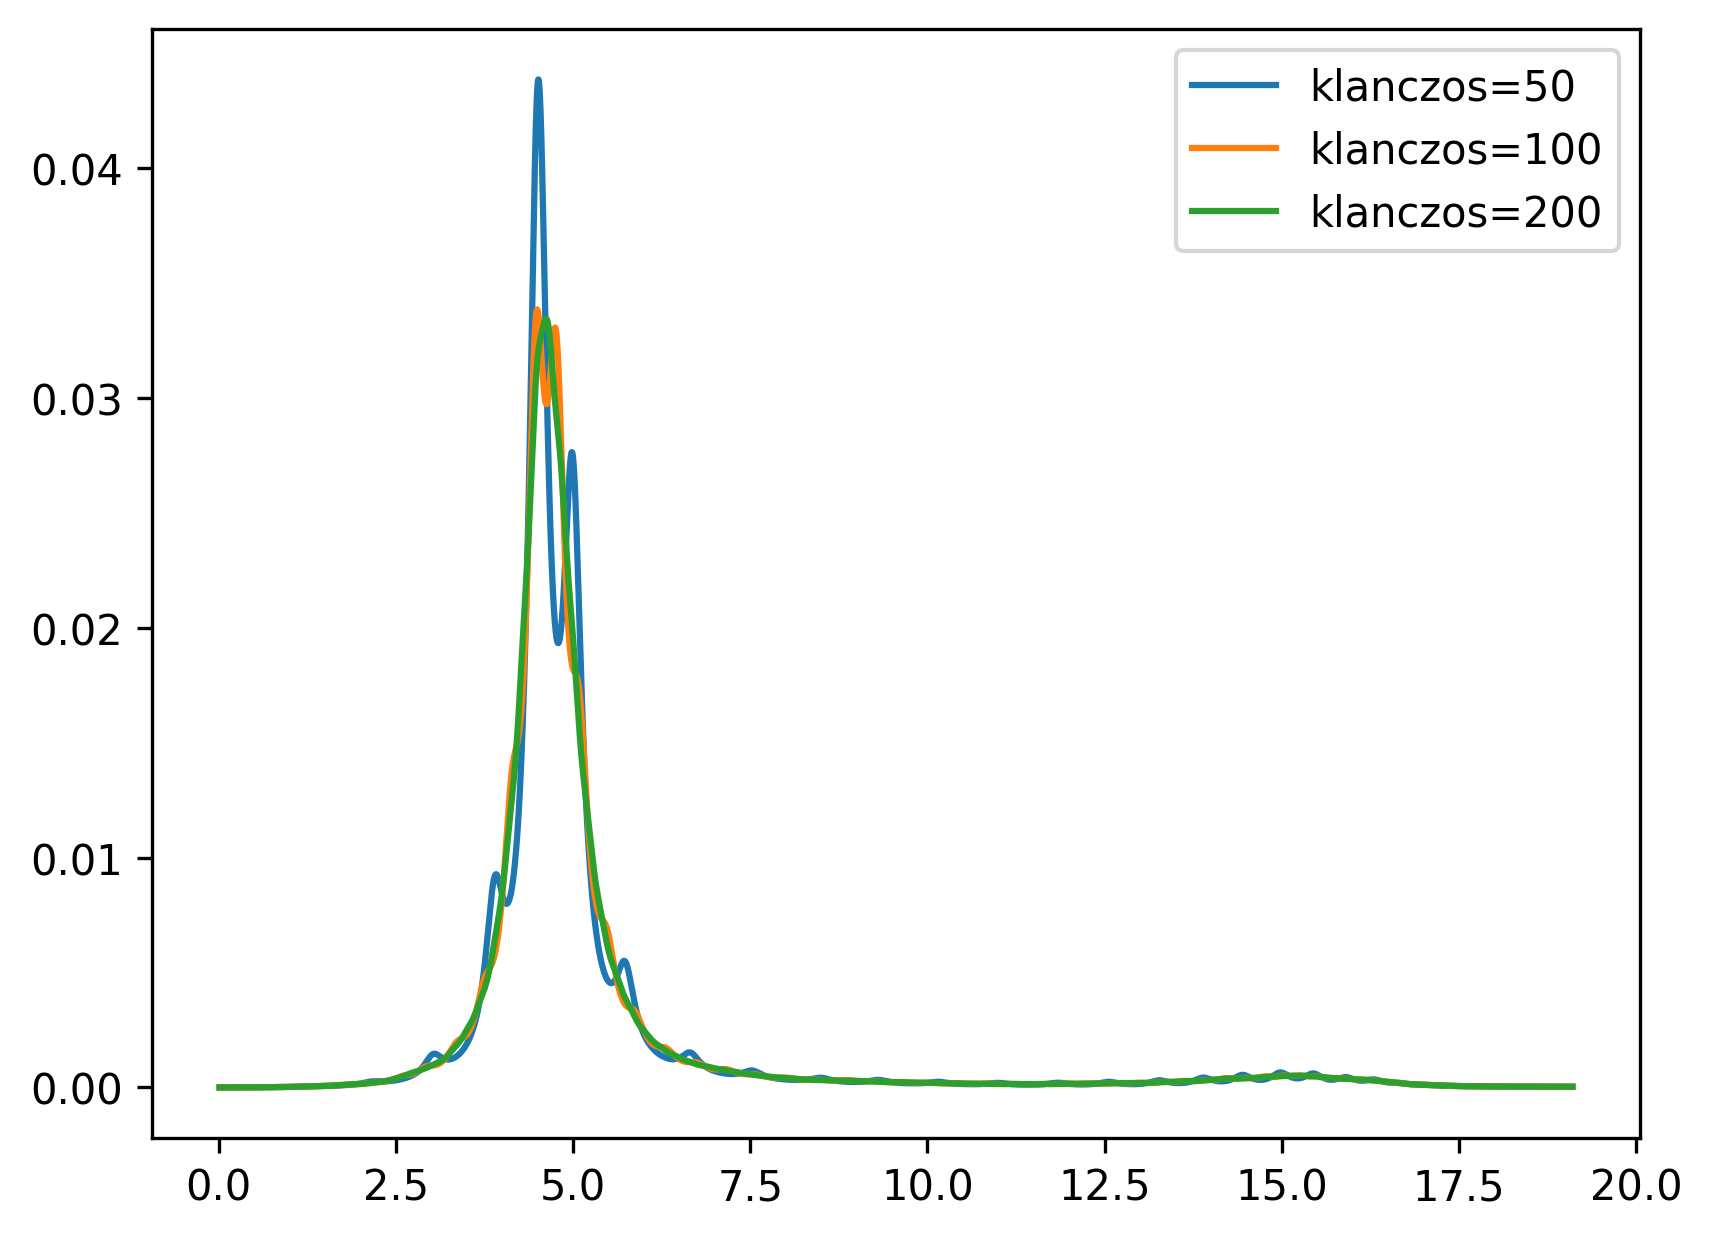

In [58]:
omega=spectrum['omega']
iq=3 ### random wavevector index
eta=1
b='L'
fig,ax=plt.subplots()
for klanczos in [int(k/4),int(k/2),k]:
    alpha=spectrum[iq][b]['alpha'][:klanczos]
    beta=spectrum[iq][b]['beta'][:klanczos]
    alpha=np.append(alpha,1)
    beta=np.append(beta,0)
    z2=(omega+1j*eta)**2
    y=lanczos.recompute_spectrum(alpha,beta,z2)
    ax.plot(omega/2/np.pi,(omega/2/np.pi)*y,label='klanczos={}'.format(klanczos))

plt.legend()
plt.show()

# Comparison direct vs haydock

## Load direct diagonalization data

In [59]:
direct_spectrum=np.load(root+'S_Qw_har_direct.eta{}.no2pi.npy'.format(eta),allow_pickle=True).item()
eigval=np.load(root+'eigval.npy')
eigvec=np.load(root+'eigvec.npy')

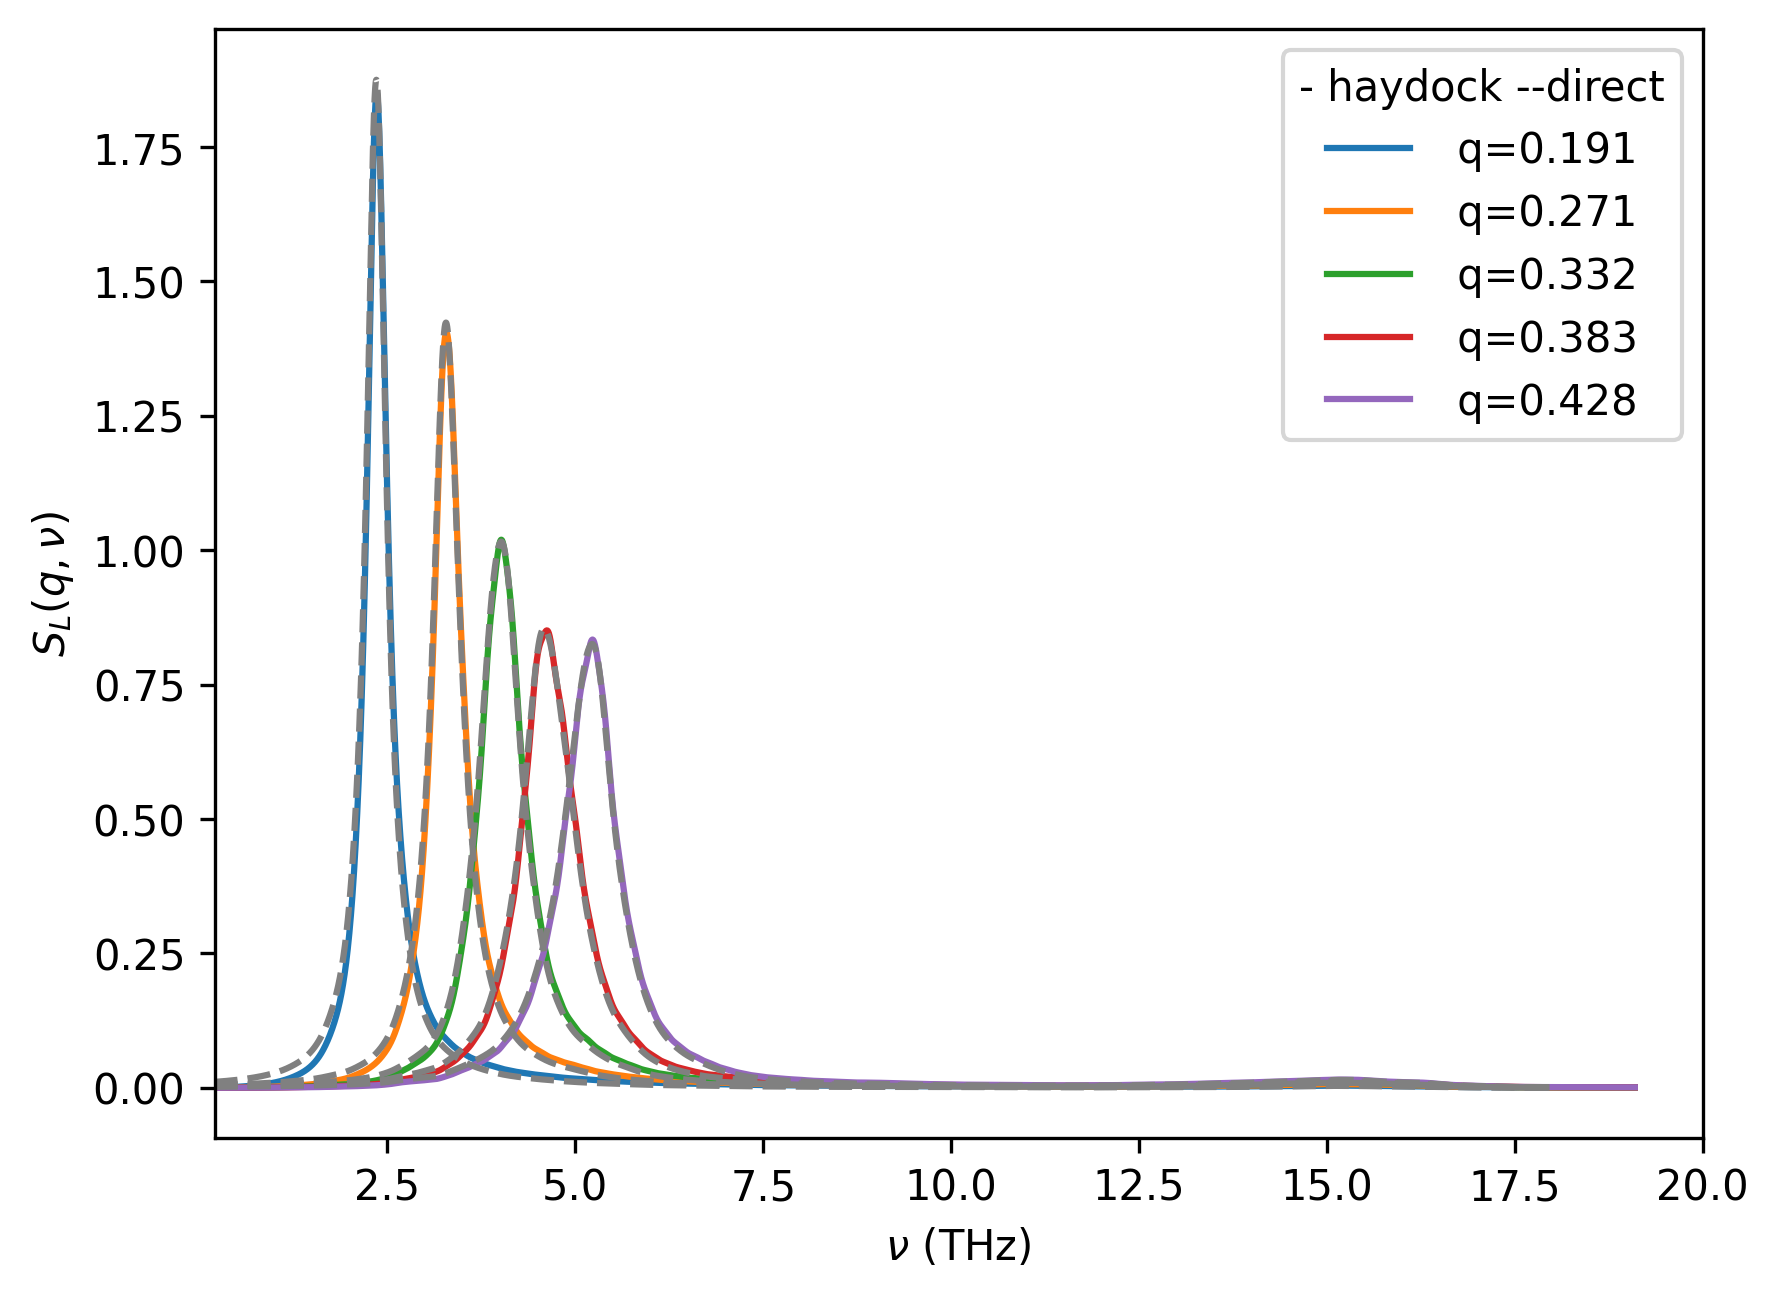

In [49]:
eta=1
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
fig,ax=plt.subplots()
w=spectrum['omega']
dw_ref=w[1]-w[0]
for iq in [0,1,2,3,4]:
    x=w
    y=(x/2/np.pi)*S_qw[0,iq,:]
    norm=np.trapz(y,x/2/np.pi)
    ax.plot(x/2/np.pi,y/norm,ls='-',color=colors[iq],label=' q='+str(np.round(q[iq],3)) )
for iq in [0,1,2,3,4]:
    x=direct_spectrum['omega']
    y=direct_spectrum['S']['L'][iq,:,0]
    norm=np.trapz(y,x/2/np.pi)
    ax.plot(x/2/np.pi,y/norm,'--',color='gray')
plt.xlim(0.2,20)
# plt.ylim(0,1)
plt.legend(title='- haydock --direct')
plt.ylabel(r'$S_L(q,\nu)$')
plt.xlabel(r'$\nu\mathrm{~(THz)}$')
plt.show()

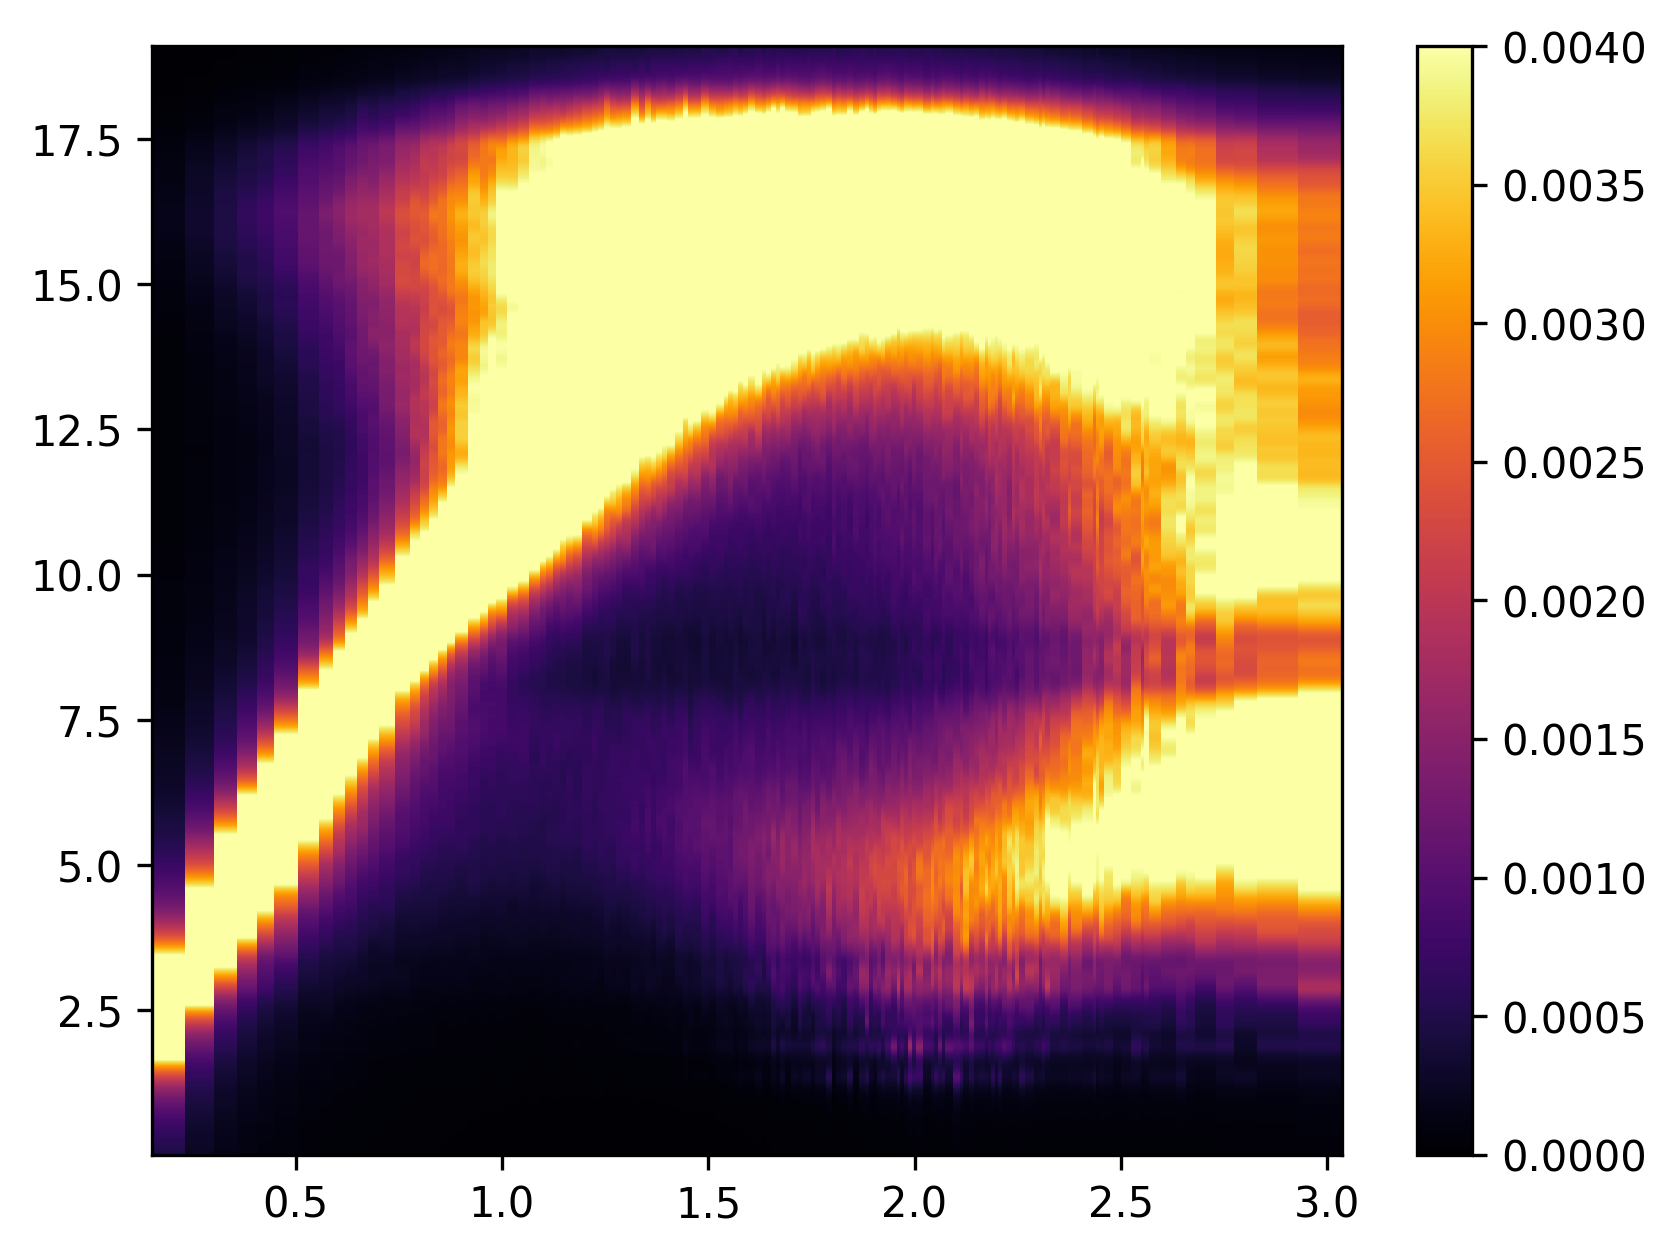

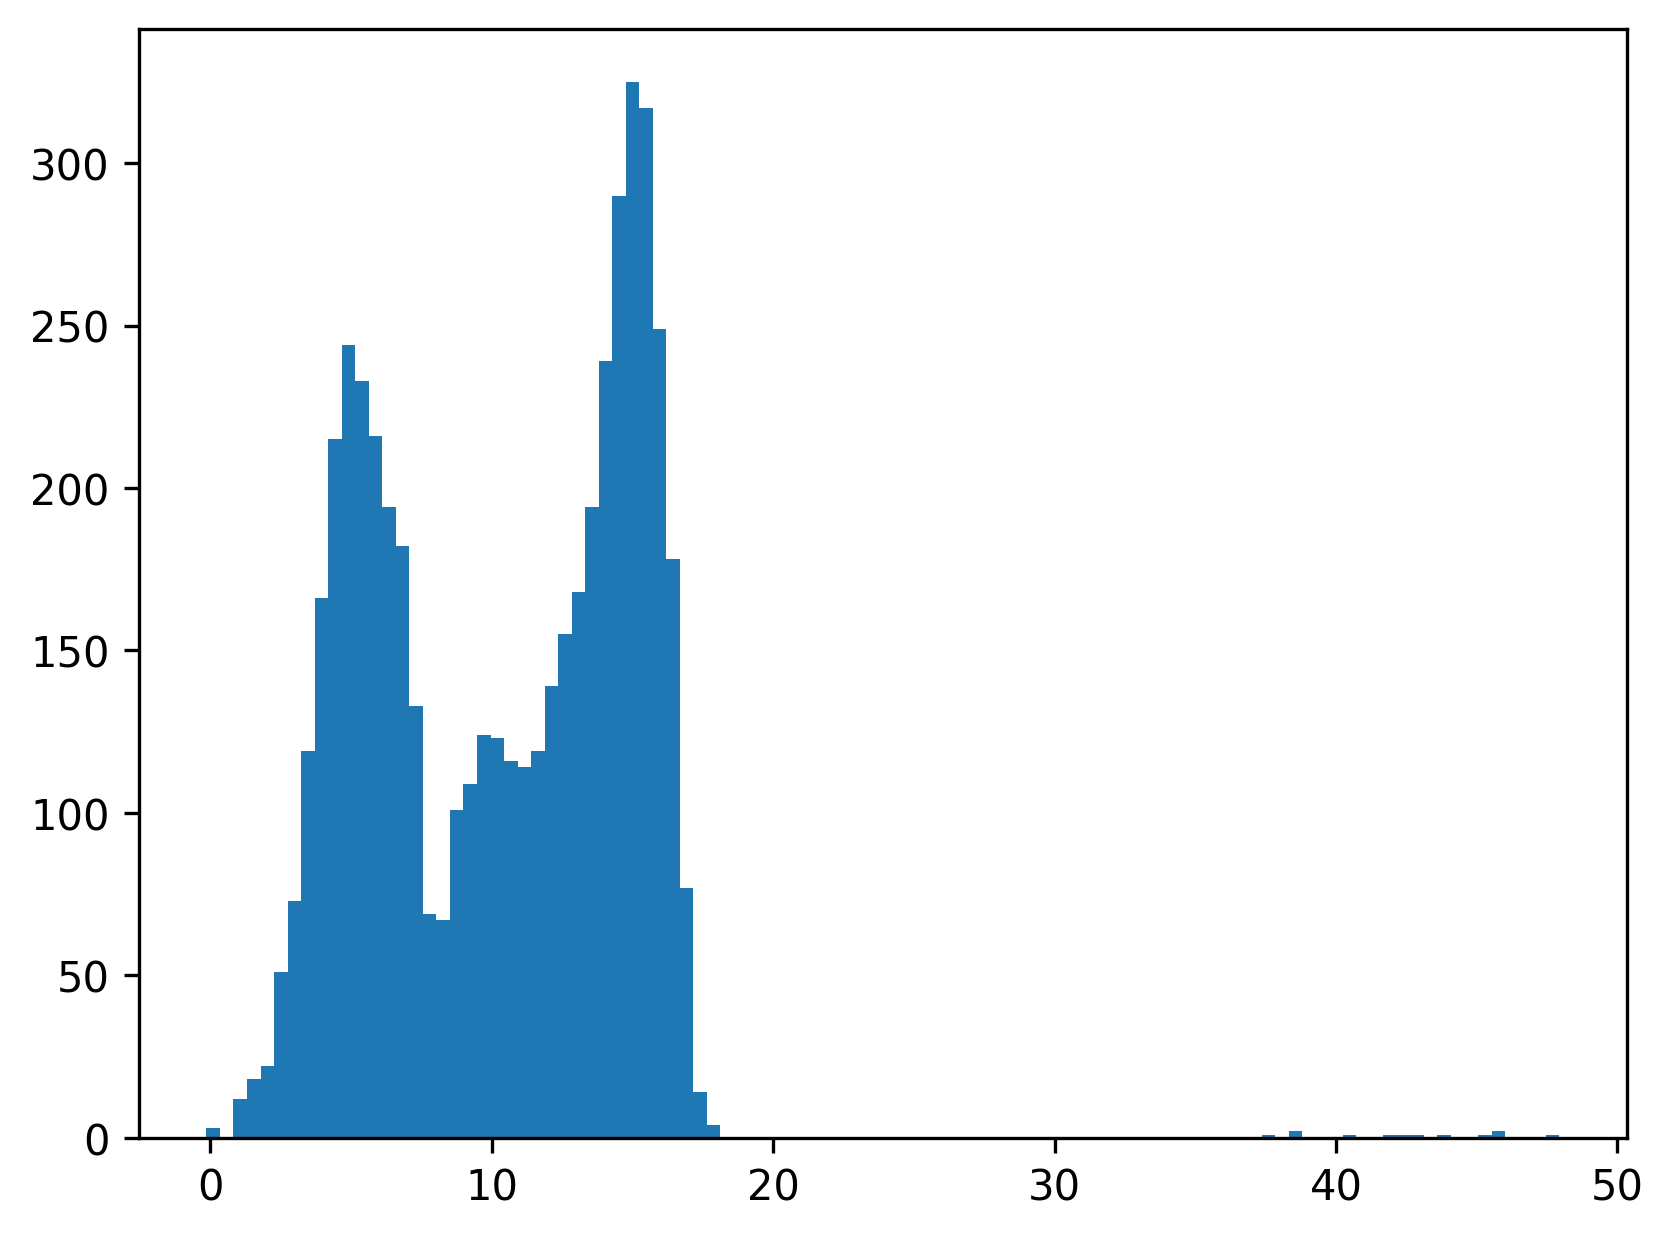

In [52]:
mode='L' #or T (Longitudinal or Tranverse)
fig,ax=plt.subplots()
Q=direct_spectrum['Q']
S=direct_spectrum['S']
p0=ax.pcolormesh(np.linalg.norm(Q,axis=1),omega/2/np.pi,S[mode][:,:,0].T,
                      shading = 'nearest',
                      vmin = 0,
                      vmax = vmax,
                      cmap = 'inferno')
fig.colorbar(p0, ax=ax)
##VDOS
fig,ax=plt.subplots()
f=np.sign(eigval)*np.sqrt(np.abs(eigval))/2/np.pi
ax.hist(f,bins=100)
plt.show()

Text(0.5, 0.98, '$S(q,\\nu)$')

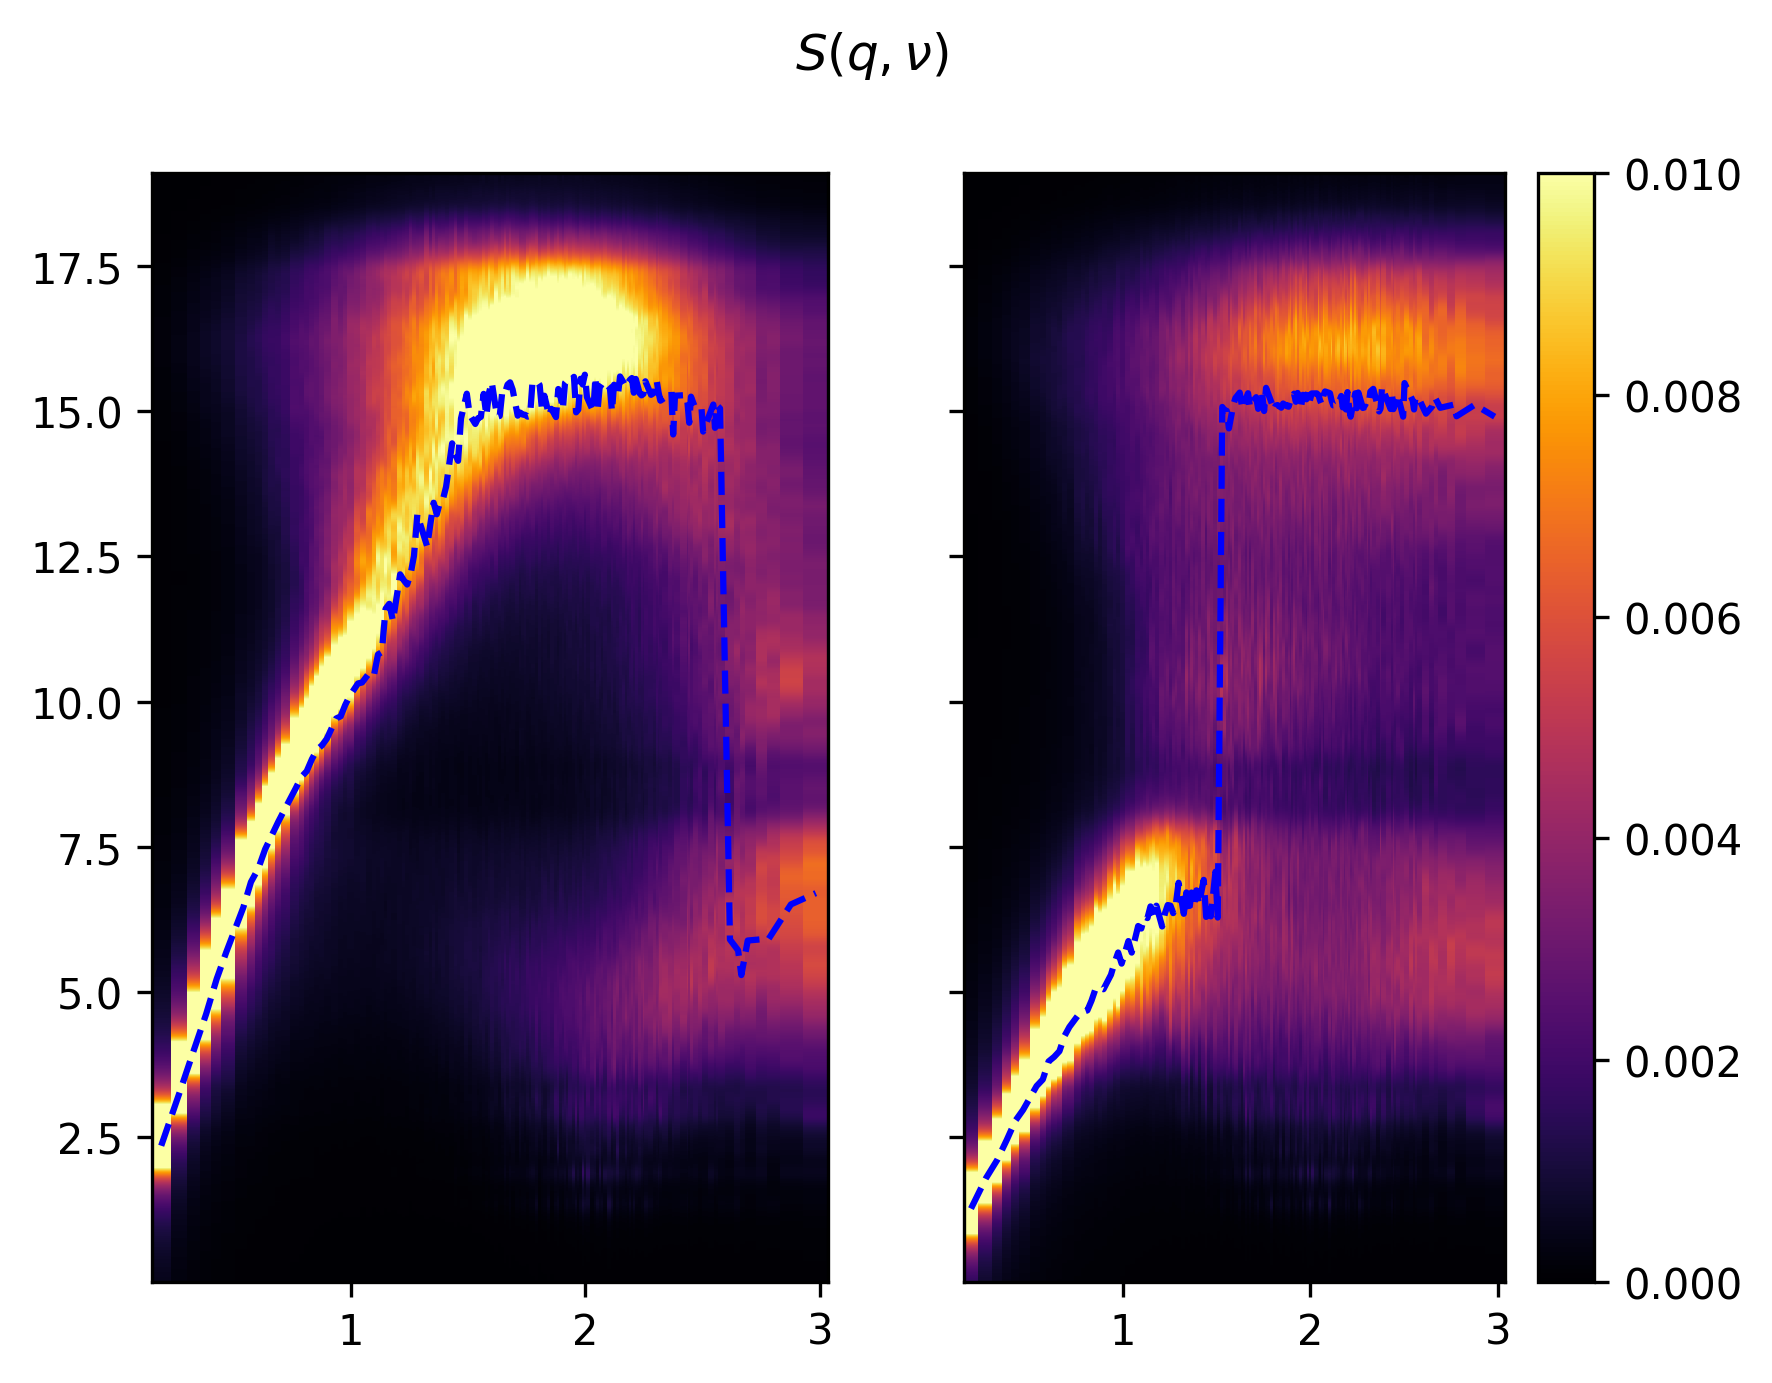

In [62]:
fig,axes=plt.subplots(ncols=2,sharey=True)
vmax=1e-2
for imode,mode in enumerate(['L','T']):
    ax=axes[imode]
    Q=direct_spectrum['Q']
    S=direct_spectrum['S']
    q=np.linalg.norm(Q,axis=1)
    p=ax.pcolormesh(q,w/2/np.pi,S[mode][:,:,0].T,
                          shading = 'nearest',
                          vmin = 0,
                          vmax = vmax,
                          cmap = 'inferno'
                 )
    dispersion=w[np.argmax(w[np.newaxis,:]*S_qw[imode,:,:],axis=1)] ### it should give the acoustic dispersion in the lower frequency part
    # print(T_dispersion.shape)
    ax.plot(q,dispersion/2/np.pi,'--',color='b')
    if imode==1:
        fig.colorbar(p, ax=ax)
fig.suptitle('$S(q,\\nu)$')
